<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Laboratorio: Construcción Modelo de Clasificación y Evaluación de Métricas

Tras realizar el preprocesamiento de los datos y dejarlos listos para construir modelos, ha llegado el momento de dar el siguiente paso: desarrollar tu **primer modelo de clasificación**.

El objetivo de este laboratorio es implementar un modelo de clasificación inicial utilizando **Regresión Logística (Logistic Regression)**. Este modelo te permitirá obtener las primeras predicciones para identificar transacciones normales y anómalas, así como evaluar su desempeño utilizando métricas estándar.

Además, deberás evaluar si el modelo está en riesgo de **overfitting**, asegurando que nuestras predicciones sean consistentes tanto en los datos de entrenamiento como en los de prueba.


## Objetivo del Laboratorio

1. Entrenar un modelo de **Regresión Logística** para predecir si una transacción es "Normal" o "Anómala".

2. Evaluar el desempeño del modelo utilizando métricas como:

   - Precisión (Accuracy).

   - Matriz de confusión.

   - Precisión (Precision), exhaustividad (Recall) y F1-Score.

   - Área bajo la curva ROC (AUC-ROC).

3. Determinar si el modelo presenta **overfitting** o **underfitting**, analizando el rendimiento en los datos de entrenamiento y prueba.


In [31]:
# Para no tener que hacer restart con cada actualizacion 

%load_ext autoreload
%autoreload 2



# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.float_format = "{:,.2f}".format    #para la notación
pd.set_option("display.max_columns", None)
import pickle

from itertools import product, combinations

from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
import tqdm as tqdm
from scipy.stats import chi2_contingency
import os
import sys 
sys.path.append(os.path.abspath("../src"))   
import soporte_preprocesamiento_log as f

# Para tratar el problema de desbalance
# -----------------------------------------------------------------------
# from imblearn.over_sampling import RandomOverSampler, SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.combine import SMOTETomek


from sklearn.model_selection import train_test_split,GridSearchCV
# Para realizar la clasificación y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MÉTRICAS DE LOGÍSTICA (para variable dependiente binaria)

In [32]:
with open('../pickles_general/datos_preprocesados.pkl', 'rb') as r:
    df_preprocesado = pickle.load(r)  

In [33]:
df_preprocesado.head(2)

,customer_id,merchant_id,amount,is_fraudulent,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,location_City-1,location_City-10,location_City-11,location_City-12,location_City-13,location_City-14,location_City-15,location_City-16,location_City-17,location_City-18,location_City-19,location_City-2,location_City-20,location_City-21,location_City-22,location_City-23,location_City-24,location_City-25,location_City-26,location_City-27,location_City-28,location_City-29,location_City-3,location_City-30,location_City-31,location_City-32,location_City-33,location_City-34,location_City-35,location_City-36,location_City-37,location_City-38,location_City-39,location_City-4,location_City-40,location_City-41,location_City-42,location_City-43,location_City-44,location_City-45,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9
0,0.82,0.26,0.58,0,0.90,0.48,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.14,0.53,0.19,1,0.14,0.83,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


**Separamos la X y la Y**

In [34]:
x= df_preprocesado.drop(columns="is_fraudulent")
y= df_preprocesado["is_fraudulent"]

**Separamos TRAIN y TEST**

In [35]:
params_logistic = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.005, 0.01,0.05, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10,20,40,100,150]
}

In [36]:
x_train,x_test,y_train,y_test= train_test_split(x,y,train_size=0.8, random_state=42, shuffle=True)
modelo_logi= LogisticRegression()
# Ajuste del modelo
grid_search_logistica = GridSearchCV(estimator=modelo_logi, 
                                param_grid=params_logistic, 
                                cv=5, 
                                scoring='accuracy')

grid_search_logistica.fit(x_train,y_train)
modelo_final_logistica = grid_search_logistica.best_estimator_

# Ajustar el modelo con los datos de entrenamiento
modelo_final_logistica.fit(x_train, y_train)

# Hacer las predicciones para los datos
y_pred_train = modelo_final_logistica.predict(x_train)
y_pred_test = modelo_final_logistica.predict(x_test)

# Obtener Probabilidades predichas
y_pred_train_prob = modelo_final_logistica.predict_proba(x_train)[:,1]
y_pred_test_prob = modelo_final_logistica.predict_proba(x_test)[:,1]


In [37]:
modelo_final_logistica

LogisticRegression(C=0.05, max_iter=10, penalty='l1', solver='liblinear')

In [38]:
with open('../pickles_general/modelo_logi1.pkl', 'wb') as l:
    pickle.dump(modelo_final_logistica, l)

In [39]:

# modelo_logi.fit(x_train,y_train)



# y_pred_train_prob = modelo_logi.predict_proba(x_train)[:, 1]  #cogemos todas las probabilidades de que pertenezca al grupo 1
# y_pred_test_prob = modelo_logi.predict_proba(x_test)[:, 1]
# y_pred_train=modelo_logi.predict(x_train)
# y_pred_test=modelo_logi.predict(x_test)
                  
# y_pred_test[:10]

In [40]:
df_pred=pd.concat([y_test.reset_index(drop=True),pd.DataFrame(y_pred_test)], axis=1)    #ypred_test es un array y tienen que ser dataFRame
df_pred.columns=["Real", "Predicho"]
df_pred.head()

,Real,Predicho
0,1,1
1,0,1
2,0,1
3,1,1
4,1,1


#### CONFUSION MATRIX (Es para contar el número de falsos negativos y falsos positivos (también da los Verdaderos)

In [41]:
matriz_confusion=confusion_matrix(y_test, y_pred_test)       #Esto nos devuelve un array y por eso vamos a hacer un hitmap
matriz_confusion

array([[128, 838],
       [122, 912]])

In [42]:
metricas=f.calcular_metricas(y_train, y_test, y_pred_train, y_pred_test,y_pred_test_prob,y_pred_train_prob)
metricas.T

,accuracy,precision,recall,f1,kappa,auc
train,0.51,0.51,0.51,0.43,0.01,0.52
test,0.52,0.52,0.52,0.44,0.01,0.54


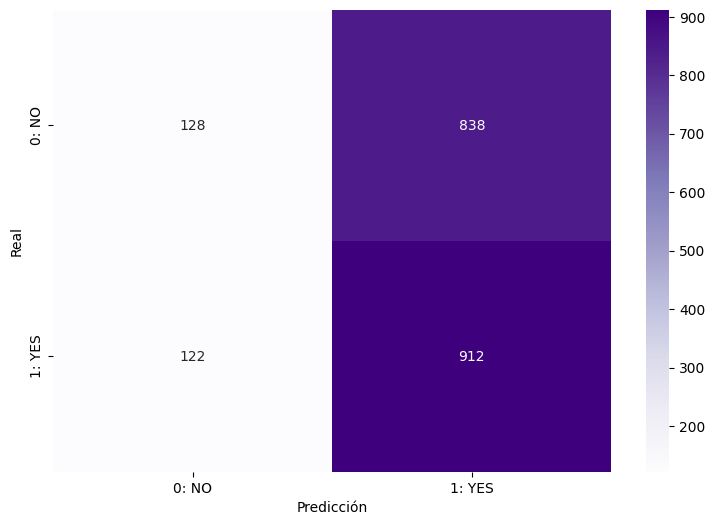

In [43]:
f.plot_matriz_confusion(matriz_confusion, invertir=False, tamano_grafica=(9,6), labels=True, label0="NO", label1="YES")

#### METRICAS   
###### Verdaderos Positivos(VP), Verdaderos Negativos (VN), Falsos Negativos (FN) y Falsos Positivos (FP)
- ***Accuracy***= (VP + VN)/Total   (**Como de bien estoy prediciendo los casos Verdaderos (No es fiable si hay desbalanceo)**)  
  
- ***Precision***= VP/(VP + FP)   (**Como de seguros estamos de que los valores positivos predichos son correctos (porporción de VP respecto al total de positivos predichos)**)  
  
- ***Recall/Sensibilidad***= VP/(VP + FN)   (**De todos los casos realmente positivos cuantos acertamos (porporción de VP respecto al total de positivos reales)**)  

###### Si prefiero tener FP (cáncer)  ***Precision*** será más bajo, pero prefiero tener un ***Recall*** más alto porque no quiero tener FN    
###### Si prefiero tener FN (curriculums)  ***Recall*** será más bajo, pero no me importa porque prefiero tener un ***Precision*** más alto porque no quiero tener FP    
  

- ***F1***= 2*(Precision * Recall)/Precision * Recall (**Media Armónica entre Precision y Recall  (Para cuando los datos son Desbalanceados) (Representa el Balance entre Precision y Recall)(Buscamos el equilibrio pero no nos da la información si da malo de cual de los dos es el que está dando un valor malo si el Recall o el Precision)**)    
  
  
- ***Especificidad***= VN/(VN + FP)   (**De todos los casos realmente negativos cuantos acertamos (porporción de VN respecto al total de negativos reales)**)  
  
  
- ***Kappa***= VP/(VP + FP)   (**Cuanto mayor mejor, si <= 0.5 es bastante probable que nuestras predicciones sean fruto del azar si >0.6 puede ser azar pero menos probable > 0.8 es consistente decir que nuestras predicciones no son fruto del azar  y si es 1 es que no se deja nada al azar(mide si nuestras predicciones son resultado del azar o no)**)    


**TPR** RATIO VERDADEROS POSITIVOS VP/(VP+FN) según aumentamos el umbral(threshold) a partir de cuando se convierten en 1 va habiendo menos 1 y más 0 con lo cual mayor probabilidad de FN (porque en umbral > 0,6 un 0,67 te lo pone como 1 pero con umbral > 0,8 te lo pone como 0) Por ello aumenta el número de FP y menos VN  
  
**FPR** RATIO FALSOS NEGATVOS (1-ESPECIFICIDAD) FP/(VN+FP) según aumentamos el umbral a partir de cuando se convierten en 1 va habiendo menos 1 y más 0 con lo cual mayor probabilidad de FN (porque en umbral > 0,6 un 0,67 te lo pone como 1 pero con umbral > 0,8 te lo pone como 0). Por ello aumenta el número de VN y menos FP
  


In [44]:
fpr, tpr, thresholds=roc_curve(y_test, y_pred_test_prob)

#### En la curva ROC se representa que va pasando con los ratios según vamos aumentando el umbral 

Si la CURVA da por la esquina inferior es que todo mal porque estoy dando datos falsos  
Si la CURVA da por la esquina superior cuanto más se acerque a la esquina mejor (porque la esquina representa la perfección) y cuanto más cerca de la diagonal más probabilidad de que sea aleatorio.  
  
#### AUC es el area por debajo de la curva  (va de 0 a 1)
  
Cuanto más área haya (Mayor AUC) mejor  


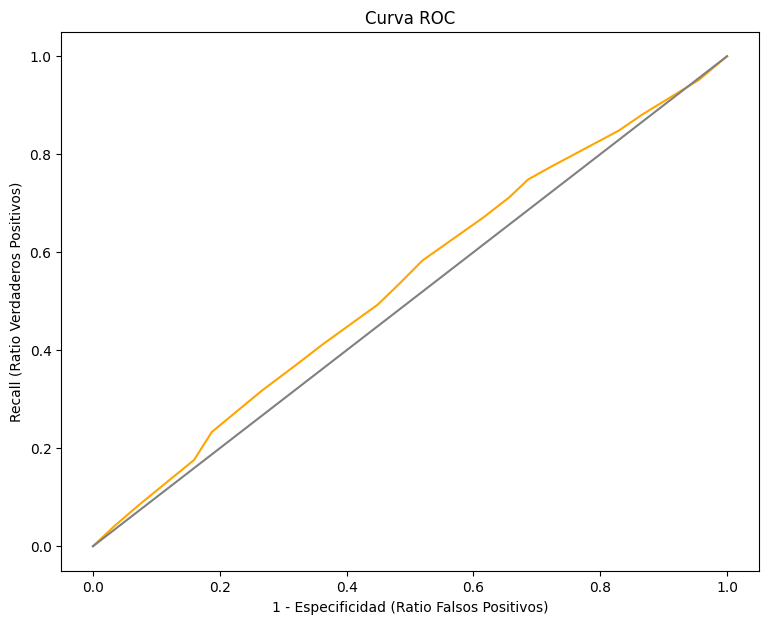

In [45]:
plt.figure(figsize=(9,7))
sns.lineplot(x=fpr,y=tpr,color="orange" )
sns.lineplot(x=[0,1], y= [0,1], color="grey")
plt.xlabel("1 - Especificidad (Ratio Falsos Positivos)")
plt.ylabel("Recall (Ratio Verdaderos Positivos)")
plt.title("Curva ROC");

Definitivamnte no voy a imputar Outliers (Iterative), no voy a meter la del tiempo porque lo hace tán especifico que hay un Over fitting Increible, no voy a usar LOF. 

Modelo 1(0.8):  
  
        accuracy precision recall	f1  kappa    auc
    train	0.55	0.55	0.55	0.55	0.11	0.57
    test	0.53	0.53	0.53	0.53	0.06	0.54


Modelo 1(0.7):  
   
        accuracy precision recall	f1  kappa    auc
    train	0.55	0.55	0.55	0.55	0.10	0.57
    test	0.53	0.53	0.53	0.53	0.06	0.54


Modelo 2(outliers imputados(Iterative))(0.7):  
   
        accuracy precision recall	f1  kappa    auc
    train	0.55	0.55	0.55	0.55	0.10	0.58
    test	0.53	0.53	0.53	0.53	0.05	0.53
  

Modelo 2(outliers imputados(Iterative))(0.8):  
  
        accuracy precision recall	f1  kappa    auc
    train	0.55	0.55	0.55	0.55	0.10	0.58
    test	0.51	0.51	0.51	0.51	0.02	0.53
  

Modelo 3(sin columna transaction_time)(0.8):  
   
        accuracy precision recall	f1  kappa    auc
    train	0.62	0.62	0.62	0.62	0.24	0.68
    test	0.52	0.52	0.52	0.52	0.03	0.53   


Modelo 3(sin columna transaction_time)(0.7):  
   
        accuracy precision recall	f1  kappa    auc
    train	0.97	0.97	0.97	0.97	0.94	0.99
    test	0.51	0.51	0.51	0.51	0.03	0.51  


Modelo 4(LOF en vez de IFO)(0.8):  
   
        accuracy precision recall	f1  kappa    auc
    train	0.54	0.54	0.54	0.54	0.09	0.56
    test	0.51	0.52	0.51	0.51	0.03	0.51   


Modelo 4(LOF en vez de IFO)(0.7):  
   
        accuracy precision recall	f1  kappa    auc
    train	0.55	0.55	0.55	0.55	0.09	0.57
    test	0.51	0.51	0.51	0.50	0.01	0.51   
  
    
Modelo 5(arreglado age que no la estaba encodeando)(0.7):   # Tengo que repetir las de arriba tras haber arreglado esto del encoding
   
        accuracy precision recall	f1  kappa    auc
    train	0.54	0.54	0.54	0.54	0.08	0.56
    test	0.52	0.52	0.52	0.52	0.04	0.52 
  

Modelo 5(arreglado age que no la estaba encodeando)(0.8):   
  
        accuracy precision recall	f1  kappa    auc
    train	0.55	0.55	0.55	0.54	0.09	0.56
    test	0.53	0.53	0.53	0.52	0.05	0.53    

### **CONCLUSION Final**  
  
Ningún modelo parece ser adecuado porque las métricas apenas son superiores al azar.
En cuanto al mejor modelo:  
- El Modelo 3 es el más prometedor en entrenamiento, pero no generaliza nada de nada porque es demasiado especifico (Over fitting)
- El Modelo 1 (0.8) me sale como el más consistente (teniendo en cuenta la mediocridad de las métricas) porque es de los que menos Over fitting tiene (junto al Modelo 5) aunque es pobre en rendimiento. Además me quedo con este modelo porque priorizamos tener un alto Recall porque preferimos tener falsos positivos a falsos negativos.